# Announcement-on-ML
<a href='http://www.kgptalkie.com' target="_blank"> <img src='https://github.com/laxmimerit/Important-Announcement-on-ML/raw/master/kgptalkie_strips.png'/></a>

# ML Resources
|  ML Course | Description |
|:---|:---|
| [**Fine Tuning LLM with HuggingFace Transformers for NLP**](https://www.udemy.com/course/fine-tuning-llm-with-hugging-face-transformers/?referralCode=6DEB3BE17C2644422D8E) | Learn how to fine tune LLM with custom dataset. You will learn basics of transformers then fine tune LLM|
| [**Data Visualization in Python Masterclass™: Beginners to Pro**](https://bit.ly/udemy95off_kgptalkie) |  Learn to build Machine Learning and Deep Learning models using Python and its libraries like Scikit-Learn, Keras, and TensorFlow. |
| [**Python for Machine Learning: A Step-by-Step Guide**](https://bit.ly/ml-ds-project) | Learn to build Machine Learning and Deep Learning models using Python and its libraries like Scikit-Learn, Keras, and TensorFlow. |
| [**Deep Learning for Beginners with Python**](https://bit.ly/dl-with-python) | Neural Networks, TensorFlow, ANN, CNN, RNN, LSTM, Transfer Learning and Much More. |
| [**Python for Linear Regression in Machine Learning**](https://bit.ly/regression-python) | Learn to build Linear Regression models using Python and its libraries like Scikit-Learn. |
| [**Introduction to Spacy 3 for Natural Language Processing**](https://bit.ly/spacy-intro) | Learn to build Natural Language Processing models using Python and its libraries like Spacy. |
| [**Advanced Machine Learning and Deep Learning Projects**](https://bit.ly/kgptalkie_ml_projects) | Learn to build Advanced Machine Learning and Deep Learning models using Python and transformer models like BERT, GPT-2, and XLNet. |
| [**Natural Language Processing in Python for Beginners**](https://bit.ly/intro_nlp) | Learn to build Natural Language Processing Projects using Spacy, NLTK, and Gensim, and transformer models like BERT, GPT-2, and XLNet. |
| [**Deployment of Machine Learning Models in Production in Python**](https://bit.ly/bert_nlp) |  Learn to deploy Machine Learning and Deep Learning models using Python and its libraries like HuggingFace Transformers, Streamlit, FastAPI, Docker and NGINX|
| [**R 4.0 Programming for Data Science - Beginners to Pro**](https://bit.ly/r4-ml) | Learn to build Machine Learning and Deep Learning models using R and its libraries like caret, tidyverse, and keras. |


# Image classification
## Human Pose Classification

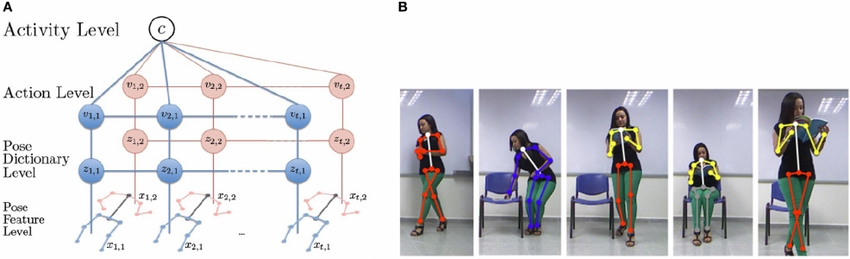

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Human_Action_Recognition", split='train')

In [4]:
dataset = dataset.shuffle().train_test_split(test_size=0.2)

In [7]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=263x192>,
 'labels': 9}

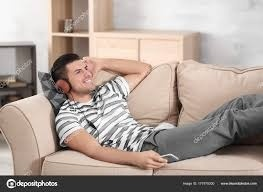

In [8]:
dataset['train'][0]['image']

In [13]:
labels = dataset['train'].features['labels'].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}
{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


## Image Preprocessing

In [14]:
from transformers import AutoImageProcessor #-> like Tokenizer

model_ckpt = "google/vit-base-patch16-224-in21k"
# model_ckpt = "microsoft/swinv2-tiny-patch4-window16-256"

In [20]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size 
        else (image_processor.size['height'], image_processor.size['width']))

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(batch):
    batch['pixel_values'] = [_transforms(img.convert('RGB')) for img in batch['image']]

    del batch['image']

    return batch

In [21]:
dataset = dataset.with_transform(transforms)

## Evaluate the model


In [22]:
# !pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Vision Transformer (ViT) Fine Tuning for Image Classification

In [25]:
from transformers import AutoModelForImageClassification
import torch

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
len(labels)

15

## Model Training

In [31]:
from transformers import TrainingArguments, Trainer


args = TrainingArguments(
    output_dir="train_dir",
    remove_unused_columns=False,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)


trainer = Trainer(
    model = model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

In [32]:
trainer.train()

  0%|          | 0/3150 [00:00<?, ?it/s]

{'loss': 2.0185, 'grad_norm': 5.299195289611816, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.79}


  0%|          | 0/158 [00:00<?, ?it/s]

{'eval_loss': 1.3407293558120728, 'eval_accuracy': 0.7392857142857143, 'eval_runtime': 25.3864, 'eval_samples_per_second': 99.266, 'eval_steps_per_second': 6.224, 'epoch': 1.0}
{'loss': 1.2611, 'grad_norm': 3.349648952484131, 'learning_rate': 1.3650793650793652e-05, 'epoch': 1.59}


  0%|          | 0/158 [00:00<?, ?it/s]

{'eval_loss': 1.057487964630127, 'eval_accuracy': 0.75, 'eval_runtime': 25.2933, 'eval_samples_per_second': 99.631, 'eval_steps_per_second': 6.247, 'epoch': 2.0}
{'loss': 1.0057, 'grad_norm': 7.883591175079346, 'learning_rate': 1.0476190476190477e-05, 'epoch': 2.38}


  0%|          | 0/158 [00:00<?, ?it/s]

{'eval_loss': 0.9362523555755615, 'eval_accuracy': 0.7634920634920634, 'eval_runtime': 24.4455, 'eval_samples_per_second': 103.087, 'eval_steps_per_second': 6.463, 'epoch': 3.0}
{'loss': 0.9019, 'grad_norm': 3.3363969326019287, 'learning_rate': 7.301587301587301e-06, 'epoch': 3.17}
{'loss': 0.829, 'grad_norm': 5.09972620010376, 'learning_rate': 4.126984126984127e-06, 'epoch': 3.97}


  0%|          | 0/158 [00:00<?, ?it/s]

{'eval_loss': 0.9091313481330872, 'eval_accuracy': 0.7571428571428571, 'eval_runtime': 24.5737, 'eval_samples_per_second': 102.549, 'eval_steps_per_second': 6.43, 'epoch': 4.0}
{'loss': 0.783, 'grad_norm': 7.277873992919922, 'learning_rate': 9.523809523809525e-07, 'epoch': 4.76}


  0%|          | 0/158 [00:00<?, ?it/s]

{'eval_loss': 0.8690993785858154, 'eval_accuracy': 0.7742063492063492, 'eval_runtime': 24.3855, 'eval_samples_per_second': 103.34, 'eval_steps_per_second': 6.479, 'epoch': 5.0}
{'train_runtime': 1497.3598, 'train_samples_per_second': 33.659, 'train_steps_per_second': 2.104, 'train_loss': 1.116756582108755, 'epoch': 5.0}


TrainOutput(global_step=3150, training_loss=1.116756582108755, metrics={'train_runtime': 1497.3598, 'train_samples_per_second': 33.659, 'train_steps_per_second': 2.104, 'total_flos': 3.906051336688435e+18, 'train_loss': 1.116756582108755, 'epoch': 5.0})

In [33]:
trainer.evaluate()

  0%|          | 0/158 [00:00<?, ?it/s]

{'eval_loss': 0.8787271976470947,
 'eval_accuracy': 0.7706349206349207,
 'eval_runtime': 24.4654,
 'eval_samples_per_second': 103.002,
 'eval_steps_per_second': 6.458,
 'epoch': 5.0}

In [34]:
trainer.save_model('vit-human-pose-classification')

## Classification Report and Confusion Matrix

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
logits = trainer.predict(dataset['test'])

  0%|          | 0/158 [00:00<?, ?it/s]

In [59]:
logits = logits.predictions

In [61]:
y_pred = np.argmax(logits, axis=1)

In [67]:
y_true = [x['labels'] for x in dataset['test']]

In [69]:
print(classification_report(y_true, y_pred, target_names=labels))

                    precision    recall  f1-score   support

           calling       0.63      0.74      0.68       144
          clapping       0.77      0.76      0.76       170
           cycling       0.95      0.93      0.94       178
           dancing       0.77      0.81      0.79       163
          drinking       0.82      0.77      0.79       177
            eating       0.87      0.86      0.86       168
          fighting       0.82      0.77      0.79       170
           hugging       0.75      0.81      0.78       186
          laughing       0.76      0.79      0.77       156
listening_to_music       0.80      0.67      0.73       181
           running       0.85      0.81      0.83       180
           sitting       0.57      0.71      0.63       134
          sleeping       0.89      0.80      0.84       176
           texting       0.63      0.63      0.63       171
      using_laptop       0.75      0.75      0.75       166

          accuracy                    

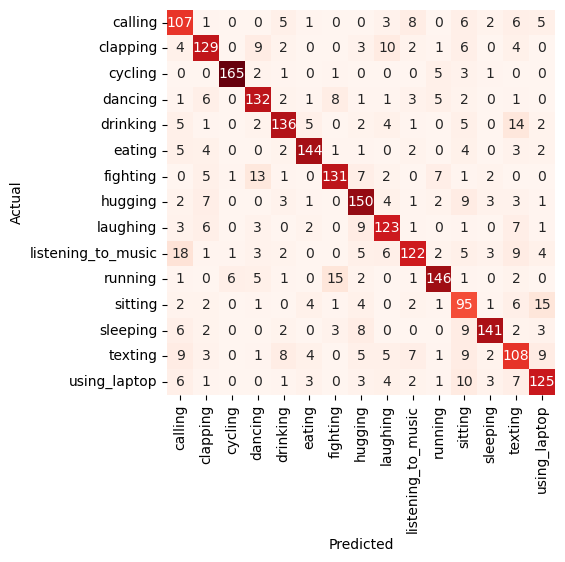

In [73]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Prediction on Real Image

In [1]:
from transformers import pipeline
from transformers import AutoImageProcessor

model_ckpt = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)

pipe = pipeline('image-classification', model='vit-human-pose-classification', 
                image_processor=image_processor)

url = "https://images.pexels.com/photos/1755385/pexels-photo-1755385.jpeg"

output = pipe(url)
output

c:\Users\laxmi\anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[{'label': 'sitting', 'score': 0.9258299469947815},
 {'label': 'listening_to_music', 'score': 0.6868688464164734},
 {'label': 'texting', 'score': 0.6454225182533264},
 {'label': 'calling', 'score': 0.5815563797950745},
 {'label': 'using_laptop', 'score': 0.5696980953216553}]

In [2]:
image_processor.save_pretrained('vit-human-pose-classification')

['vit-human-pose-classification\\preprocessor_config.json']

In [1]:
# Load the model and image processor from the local directory
from transformers import AutoImageProcessor, AutoModel

local_directory = 'vit-human-pose-classification'
image_processor = AutoImageProcessor.from_pretrained(local_directory, use_fast=True)
model = AutoModel.from_pretrained(local_directory, local_files_only=True)

c:\Users\laxmi\anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Some weights of ViTModel were not initialized from the model checkpoint at vit-human-pose-classification and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Push Model to AWS S3

In [74]:
# upload model folder to s3 bucket ml-models/vit-human-pose-classification
import os
import boto3

s3 = boto3.client('s3')
bucket_name = 'mlops-kgptalkie'

def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/")
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/")
            
            s3.upload_file(file_path, bucket_name, s3_key)


upload_directory('vit-human-pose-classification', 'ml-models/vit-human-pose-classification')